# Tarea 2: Aprendizaje de Máquinas

### Autor: Arturo Lazcano

#### Profesor: Felipe Tobar
#### Auxiliares: Catherine Benavides, Camila Bergasa, Víctor Caro, Camilo Carvajal, Diego Cortéz y Stefano Schiappacasse

### Importación Librerías



In [1]:
# Librerías principales
#!pip install --upgrade pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import display, Markdown, Latex
import matplotlib.patches as mpatches

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve
from sklearn import svm

# Gráficos
#!pip install --upgrade plotly
import plotly.express as px

# Alertas
import warnings
warnings.filterwarnings('ignore')

## P2: Pregunta Práctica

### Importación Base de Datos

In [2]:
# Leer archivo (subirlo a "files" de colab es mucho más rápido)

#from google.colab import files
#uploaded = files.upload()

In [3]:
# Leer dataframe
df = pd.read_csv('datos_tarea_2.csv', sep=';', decimal=',') 

# Semilla aleatoria
random.seed(20470051)

# Se cambia B por 0 y M por 1 en columna diagnosis
df['diagnosis'].replace('B', 0, inplace=True)
df['diagnosis'].replace('M', 1, inplace=True)

# Se cambian comas ',' por puntos '.' en columnas restantes y se cambia su tipo a float
for col in df.columns.tolist():
  if df[col].dtype == 'O':
    df[col] = df[col].apply(lambda x: str(x).replace(',','.')).astype('float')

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,872608,0,10.0,21.06,70.60,332.64,0.09699,0.12940,0.13070,0.03716,...,11.26,24.39,77.07,400.2,0.1301,0.2950,0.34860,0.09910,0.2614,0.11620
1,862980,0,10.0,22.40,69.95,328.13,0.10050,0.09697,0.06154,0.03029,...,10.76,26.83,76.22,371.2,0.1559,0.2302,0.26440,0.09749,0.2622,0.08490
2,879804,0,10.0,20.27,68.92,324.94,0.10890,0.07232,0.01756,0.01952,...,10.42,23.22,71.08,341.6,0.1415,0.1247,0.06213,0.05588,0.2989,0.07380
3,917897,0,10.0,18.68,69.00,322.52,0.09492,0.08419,0.02330,0.02416,...,11.24,22.99,78.32,386.5,0.1419,0.2243,0.08434,0.06528,0.2502,0.09209
4,864033,0,10.0,19.99,68.50,319.22,0.10370,0.08404,0.04334,0.01778,...,11.05,21.47,75.68,377.0,0.1467,0.1765,0.13000,0.05334,0.2533,0.08468


In [4]:
# Pequeño análisis exploratorio
print('Dimensiones del dataframe: \n', '\n', df.shape)
print('\n')
print('Columnas dataframe: \n')
for col in df.columns.values.tolist():
  print(col)

Dimensiones del dataframe: 
 
 (569, 32)


Columnas dataframe: 

id
diagnosis
radius_mean
texture_mean
perimeter_mean
area_mean
smoothness_mean
compactness_mean
concavity_mean
concave points_mean
symmetry_mean
fractal_dimension_mean
radius_se
texture_se
perimeter_se
area_se
smoothness_se
compactness_se
concavity_se
concave points_se
symmetry_se
fractal_dimension_se
radius_worst
texture_worst
perimeter_worst
area_worst
smoothness_worst
compactness_worst
concavity_worst
concave points_worst
symmetry_worst
fractal_dimension_worst


In [5]:
# Información del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    int64  
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

### 1. Árboles de decisión y Random Forest

#### (a)

La poda de un árbol consiste en elegir un nodo y el subárbol que posee este nodo elegido como raíz y extraerlo del conjunto (árbol) entero. Esto se hace con el objetivo de evitar el sobreajuste y disminuir la complejidad del árbol entero.  
Un criterio posible para esta poda es el de `minimal cost complexity`, y consiste en, dado una métrica $R(T)$ que represente el costo de un árbol $T$, por ejemplo, la tasa de error de clasificación, se define una nueva métrica dada por:  
$R_{\alpha}(T) = R(T) + \alpha|T|, \quad$ con $|T|$ número de hojas totales.  

Así, el parámetro $\alpha$ es el encargado de penalizar más o menos la complejidad del árbol como costo en complejidad de un nodo terminal.  
Luego, la idea del algoritmo de poda con criterio `minimal cost complexity` consiste en construir una sucesión de subárboles $T_0, T_1, ..., T_m$, con $T_0$ el árbol original, tal que en cada paso haya menos nodos terminales y $T_m$ representa la raíz. Así, el pseudo código del algoritmo es como sigue:  

```python

# Función de poda al árbol T
def Poda de costo-complejidad():

  #Función de generación de sucesión de subárboles
  def SucesionArboles(T):
    # Constantes
    k = 0
    T_0 = T
    alpha = np.inf # infinito

    for t in nodos no terminales desde abajo hacia arriba:
      r = R(T_t)
      t = |T_t|
      g = (R(T) - R(T_t)) / (|T_t| - |T|)
      alpha = min(alpha, g)

    for t in nodos no terminales de arriba hacia abajo:
      if g = alpha:
        reemplazar T_t por t # Podar
        k = k + 1
        alpha_k = alpha
        T_k = T

    if T es un árbol trivial:
      return alpha_1,..., alpha_m, T1, ..., T_m

```

Finalmente, lo que obtenemos de esto es una sucesión de subárboles y de $\alpha$'s. Así, para elegir con qué quedarse, una manera razonable de
escoger un árbol final es tomar aquel que tenga menos error en
un conjunto de entrenamiento o validación. También podemos
hacer uso de técnicas como validación cruzada.

#### (b)

In [6]:
# Separación en conjunto de entrenamiento y testeo con rut de semilla
X = df[['perimeter_worst', 'perimeter_mean']]
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 20470051)

In [7]:
# Ver balanceo de clases (B --> 0 y m --> 1)
y.value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [8]:
# Árbol simple (clasificador) con parámetros predeterminados
simpletree = DecisionTreeClassifier()

In [9]:
# Entrenamiento con conjuntos train
simpletree.fit(X_train, y_train)

DecisionTreeClassifier()

In [10]:
# Predicciones en el conjunto de entrenamiento y testeo
y_pred_train = simpletree.predict(X_train)
y_pred_test = simpletree.predict(X_test)

# Accuracy en el conjunto de entrenamiento y testeo
score_train = accuracy_score(y_train, y_pred_train)
score_test = accuracy_score(y_test, y_pred_test)
print('Accuracy en conjunto de entrenamiento:',score_train)
print('Accuracy en conjunto de testeo:',score_test)

Accuracy en conjunto de entrenamiento: 1.0
Accuracy en conjunto de testeo: 0.8771929824561403


Notar que el Accuracy en el conjunto de entrenamiento es 1, pues al no imponer hiperparámetros, estamos haciendo que cada punto sea clasificado de manera correcta, obteniendo así un 100% de predicción.

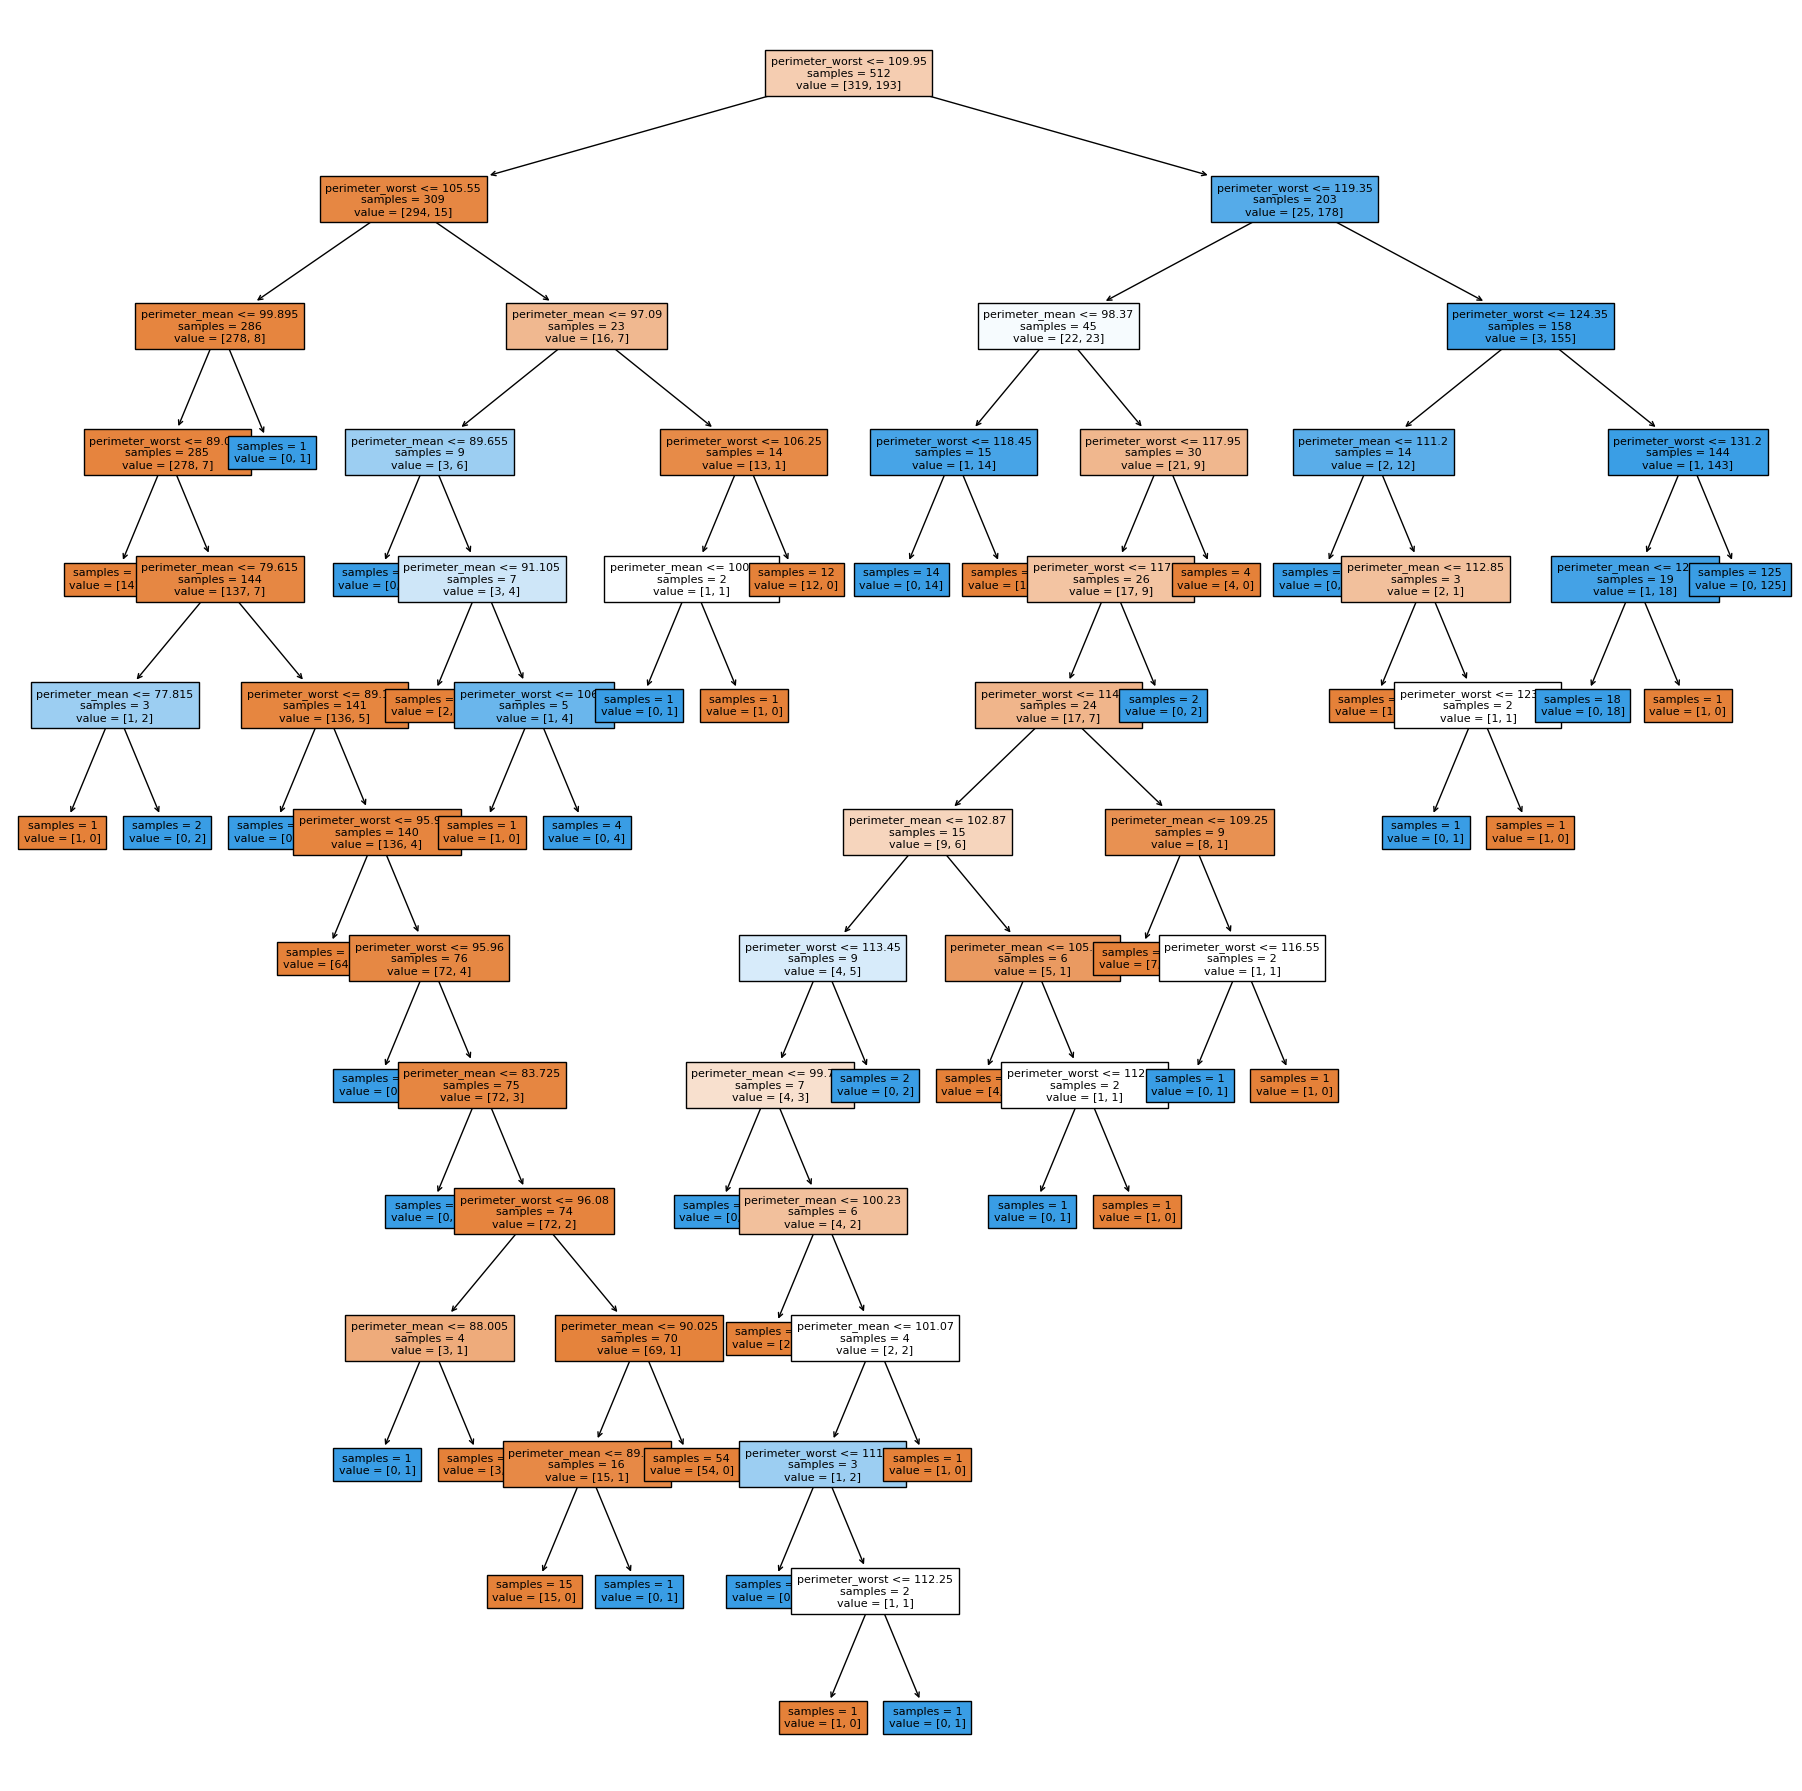

In [11]:
# Gráfico de árbol con parámetros predeterminados
plt.figure(figsize = (23,23))
plot_tree(simpletree, feature_names = X.columns, fontsize = 8, impurity = False, filled = True)
pass

In [12]:
# Profundidad del árbol
print('La profundidad del árbol es', simpletree.tree_.max_depth)

La profundidad del árbol es 13


Tanto en el gráfico como el a celda de código anterior se puede ver que la profundidad máxima del árbol es 13. Esto recordando que la raíz (primer nodo) es de profundidad 0, por lo cual se empiezan a contar desde los hijos de este nodo.

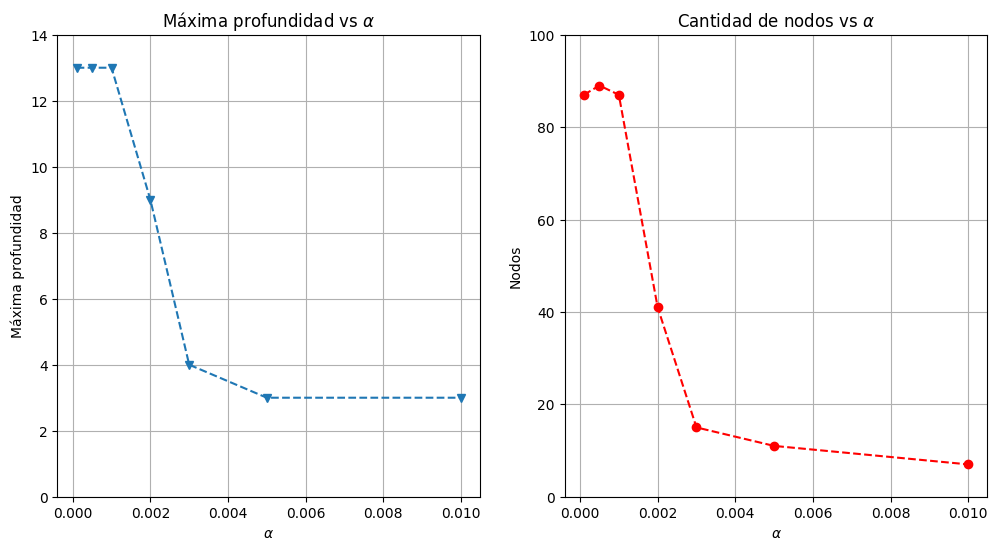

In [13]:
# Lista de alphas a considerar
alphas = [0.0001, 0.0005, 0.001, 0.002 , 0.003, 0.005, 0.01]

# Lista para guardar max_depth y nodos
profundidad = []
nodos = []

# Clasificadores para cada alpha
for alpha in alphas:
  simpletree = DecisionTreeClassifier(ccp_alpha=alpha)
  simpletree.fit(X_train, y_train)
  profundidad.append(simpletree.tree_.max_depth)
  nodos.append(simpletree.tree_.node_count)

fig, axes = plt.subplots(1,2, figsize=(12,6))
# Gráfico max_depth
axes[0].plot(alphas, profundidad, '--v')
axes[0].grid()
axes[0].set_ylim(0,14)
axes[0].set_title(r'Máxima profundidad vs $\alpha$')
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel('Máxima profundidad')

# Gráfico cantidad de nodos
axes[1].plot(alphas, nodos, '--or')
axes[1].grid()
axes[1].set_ylim(0,100)
axes[1].set_title(r'Cantidad de nodos vs $\alpha$')
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel('Nodos')
plt.show()

En estos gráficos se aprecia que tanto la profundidad máxima del árbol como la cantidad de nodos va disminuyendo en cuanto $\alpha$ va incrementando. Esto tiene sentido pues $\alpha$ actúa como un parámetro de penalización, por lo cual el árbol empieza a quedarse más pequeño.

#### (c)

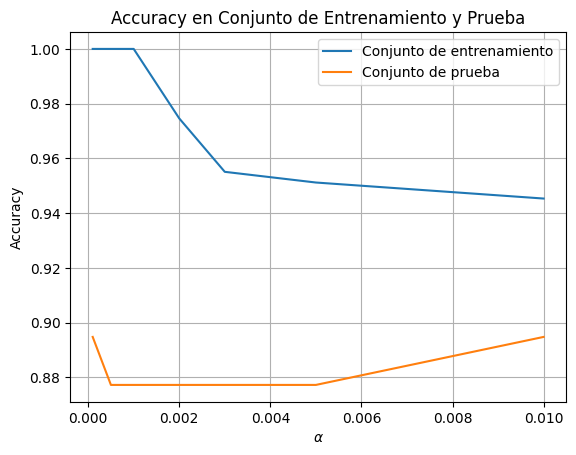

In [14]:
# Lista de alphas a considerar
alphas = [0.0001, 0.0005, 0.001, 0.002 , 0.003, 0.005, 0.01]

# Lista a guardar el score en train y test
accuracy_train = []
accuracy_test = []

# Clasificadores para cada alpha
for alpha in alphas:
  simpletree = DecisionTreeClassifier(ccp_alpha=alpha)
  simpletree.fit(X_train, y_train)
  # Predicciones en el conjunto de entrenamiento y testeo
  y_pred_train = simpletree.predict(X_train)
  y_pred_test = simpletree.predict(X_test)
  # Accuracy en el conjunto de entrenamiento y testeo
  score_train = accuracy_score(y_train, y_pred_train)
  score_test = accuracy_score(y_test, y_pred_test)
  accuracy_train.append(score_train)
  accuracy_test.append(score_test)

# Gráfico accuracy
plt.plot(alphas, accuracy_train, label='Conjunto de entrenamiento')
plt.plot(alphas, accuracy_test, label='Conjunto de prueba')
plt.grid()
plt.title('Accuracy en Conjunto de Entrenamiento y Prueba')
plt.xlabel(r'$\alpha$')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Dado el gráfico mostrado, se ve que el accuracy en el conjunto de entrenamiento va disminuyendo, sin embargo, se puede observar que en el conjunto de prueba, el accuracy va subiendo, es decir, que mientras $\alpha$ va creciendo, la robustez del modelo y su capacidad de generalización también aumenta por lo que nos quedaremos con un $\alpha = 0.01$ en este caso.  
Notar que se probaron los valores $\alpha = 0.0001, 0.0005, 0.001, 0.002 , 0.003, 0.005, 0.01$. Aumentar demasiado este hiperparámetro del modelo puede hacerlo ineficiente podándolo en exceso.

La profundidad del árbol es 3
Accuracy en conjunto de entrenamiento: 0.949748743718593
Accuracy en conjunto de testeo: 0.9181286549707602


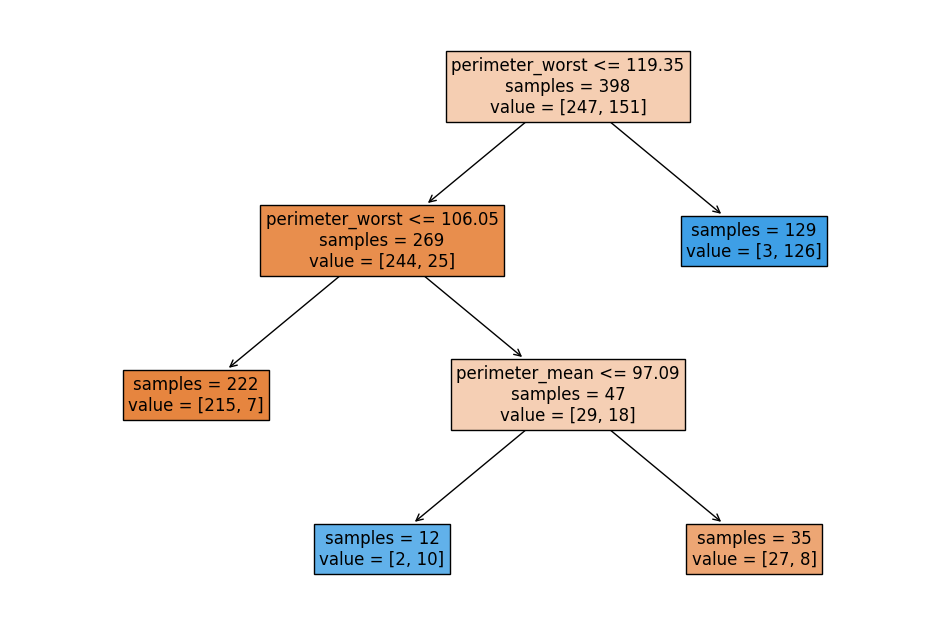

In [41]:
# Árbol con alpha = 0.01
simpletree = DecisionTreeClassifier(ccp_alpha=0.01)
simpletree.fit(X_train, y_train)

# Gráfico de árbol con alpha = 0.01
plt.figure(figsize = (12,8))
plot_tree(simpletree, feature_names = X.columns, fontsize = 12, impurity = False, filled = True)

# Máxima profundidad
print('La profundidad del árbol es', simpletree.tree_.max_depth)

# Predicciones en el conjunto de entrenamiento y testeo
y_pred_train = simpletree.predict(X_train)
y_pred_test = simpletree.predict(X_test)

# Accuracy en el conjunto de entrenamiento y testeo
score_train = accuracy_score(y_train, y_pred_train)
score_test = accuracy_score(y_test, y_pred_test)
print('Accuracy en conjunto de entrenamiento:',score_train)
print('Accuracy en conjunto de testeo:',score_test)
pass

Acá se puede observar como el árbol es bastante más compacto considerando la poda con el criterio de `minimal cost complexity` y un $\alpha=0.01$.  
Comparando este árbol con el de parámetros predefinidos, se puede ver que el accuracy en el conjunto de prueba es prácticamente idéntico, sin embargo, en el conjunto de entrenamiento, la mayor profundidad del primero modelo hace que este sea mayor que el modelo con $\alpha = 0.01$, sin embargo, podemos concluir que este score no afecta la generalización de los 2 modelos pues poseen mismo score en conjunto de prueba. Más aún, al ser el árbol podado más compacto, existe una ganancia en la fácil interpretabilidad que posee el clasificador. Es por estas dos razones que, para decidir un modelo a utilizar, se prefiere el árbol podado con $\alpha=0.01$.

#### (d)

In [16]:
# Separación en conjunto de entrenamiento y testeo con rut de semilla
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 20470051)

In [17]:
# Ver balanceo de clases (0 --> B y 1 --> M)
y.value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [18]:
# Aplicar bootstrap aggregation con árboles de sklearn

class Bagging:
  """
    Clase de bagging de árboles
  """

  def fit(self, X, y_train):
    """Fitea el bagging con los conjuntos de entrenamiento X, y

    Parameters
    ----------
    X : pandas.DataFrame
        Dataset de entrenamiento

    y_train : ndarray
        clase objetivo
    """
    # Inicializar parámetros
    self.X_train = X_train
    self.y_train = y_train
    self.B = len(self.X_train)
    self.arboles = []
    # Recorrer el número B
    for i in range(self.B):
      # Muestreo con reemplazo
      indices = np.random.choice(np.arange(self.B), size = self.B, replace = True)
      subconjunto_X = self.X_train.iloc[indices]
      subconjunto_y = self.y_train.iloc[indices]
      # árbol de decisión
      arbol = DecisionTreeClassifier()
      arbol.fit(subconjunto_X, subconjunto_y)
      self.arboles.append(arbol)

  def predict(self, X_test):
    """Predice las clases del conjunto X_test

    Parameters
    ----------
    X_test : pandas.DataFrame
        Dataset a clasificar

    Returns
    -------
    prom : ndarray 
        Promedio calculado en axis=0 del estimador y_hat de los árboles
    """
    # Definir largo de las predicciones
    y_hat = np.zeros(len(X_test))
    # Añadir la información de cada modelo (árbol)
    for arbol in self.arboles:
      y_hat = y_hat + arbol.predict(X_test)
    # Promediar y redondear para obtener un número en {0,1}
    prom = np.round(y_hat/self.B)
    return prom

In [19]:
# Crear clase, fitear y definir predicciones
bagging = Bagging()
bagging.fit(X_train, y_train)
y_pred_train = bagging.predict(X_train)
y_pred_test = bagging.predict(X_test)

In [20]:
# Definir bagging con árboles con sklearn para comparar
bagging_sklearn = BaggingClassifier(DecisionTreeClassifier())

# Entrenar bagging
bagging_sklearn.fit(X_train, y_train)
y_pred_train_2 = bagging_sklearn.predict(X_train) 
y_pred_test_2 = bagging_sklearn.predict(X_test) 

In [21]:
print('Bagging Manual: \n')
print("Accuracy en entrenamiento:", accuracy_score(y_train, y_pred_train))
print("Accuracy en test:", accuracy_score(y_test, y_pred_test))
print('\n')
print('Bagging con librería skearn: \n')
print("Accuracy en entrenamiento:", accuracy_score(y_train, y_pred_train_2))
print("Accuracy en test:", accuracy_score(y_test, y_pred_test_2))

Bagging Manual: 

Accuracy en entrenamiento: 1.0
Accuracy en test: 0.9473684210526315


Bagging con librería skearn: 

Accuracy en entrenamiento: 0.9899497487437185
Accuracy en test: 0.935672514619883


In [22]:
# Clasificador random forest
rf = RandomForestClassifier()

# Entrenar rf
rf.fit(X_train, y_train)

print("Accuracy en entrenamiento:", accuracy_score(y_train, rf.predict(X_train)))
print("Accuracy en test:", accuracy_score(y_test, rf.predict(X_test)))

Accuracy en entrenamiento: 1.0
Accuracy en test: 0.9590643274853801


La principal diferencia entre un modelo de `Bagging de árboles` y `Random Forest` que es ente último, no se selecionan todas las características del conjunto entregado, es decir, se seleccionan $m < M $ donde $M$ es el número total de *features*. Esta selección se hace de forma aleatoria, mientras que el método de bagging usa todas las $M$ variables.  

En conceptos más fundamentales, esta diferencia viene pues la varianza del algoritmo de bagging con árboles es $\rho \sigma^2 + \frac{1-\rho}{B}\sigma^2$ donde $\rho$ es la correación 2 a 2 de los estimadores, $\sigma^2$ es la varianza de cada estimador (pues son iid) y $B$ es el número de árboles. Así, RF quiere disminuir el término $\rho \sigma^2$ reduciendo la correlación de los estimadores para reducir la varianza sin afectar fuertemente el sesgo.

#### (e)

Como es sabido, el algoritmo de random forest escoge un subconjunto de variables que considera más importantes en relación a la variable target. Existen distintas formas de calcular esta importancia de variables.  
Una posible opción es el `Criterio de Gini` o `Impureza de Gini` el cual es un valor en el intervalo $[0,0.5]$ e indica informalmente la probabilidad de que un nuevo dato aleatorio sea mal clasificado si ha sido dotado de una clase al azar de acuerdo a la distribución de clases del dataset.  
Matemáticamente, si se tiene un conjunto de datos $D$ con datos de $k$ clases, denotamos $p_i$ la probabilidad de que un dato pertenezca a la clase $i$. Así, la impureza del dataset es $Gini(D) = 1-\sum_{i=1}^N p_i^2$.  
Luego, si el dataset se ha dividido por un atributo $A$ en los conjuntos $D_1, D_2$ de tamaño $n_1, n_2$ respectivamente, entonces la impureza de Gini resulta:  
$Gini_A(D) = \frac{n_1}{n} Gini(D_1) + \frac{n_2}{n} Gini(D_2), \quad$ donde $n=n_1+n_2$.  
Con estas definiciones, se escoge el atributo con menor impureza de Gini. En caso de tener varios árboles, se pueden promediar estos valores para obtener una "importancia final".  

Por otro lado, existen otros criterios de importanciaque no se detallarán por temas de espacio, tales como el criterio de `entropía` y `log_loss` que están relacionados con la teoría de la información (Shannon).

### 2. Support vector machines

#### (a)

In [23]:
# Separación en conjunto de entrenamiento y testeo con rut de semilla
X = df[['perimeter_worst', 'perimeter_mean']]
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 20470051)

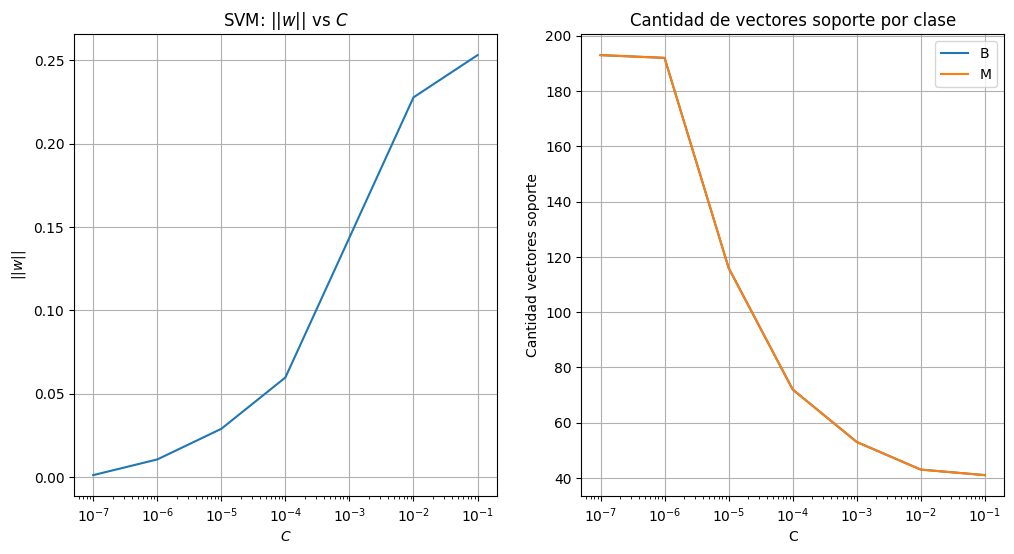

In [24]:
# Lista de c_i del enunciado y de futuras ||w||
lista_c = [10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1]
lista_w = []
n_vec_sop = []

# Clasificadores SVM
for c in lista_c:
  clf = svm.SVC(kernel='linear', C=c)
  clf.fit(X_train, y_train)
  lista_w.append(clf.coef_)
  n_vec_sop.append(clf.n_support_)

# Calcular normas a cada vector
norma_w = [np.linalg.norm(w) for w in lista_w]

fig, axes = plt.subplots(1,2, figsize=(12,6))
# Gráfico ||w||
axes[0].plot(lista_c, norma_w)
axes[0].grid()
axes[0].set_title(r'SVM: $||w||$ vs $C$')
axes[0].set_xlabel(r'$C$')
axes[0].set_ylabel(r'$||w||$')
axes[0].set_xscale('log')

# Gráfico número de vectores soporte por clase
axes[1].plot(lista_c, [item[0] for item in n_vec_sop], label = 'B')
axes[1].plot(lista_c, [item[1] for item in n_vec_sop], label = 'M')
axes[1].grid()
axes[1].set_title(r'Cantidad de vectores soporte por clase')
axes[1].set_ylabel('Cantidad vectores soporte')
axes[1].set_xlabel('C')
axes[1].set_xscale('log')
axes[1].legend()
plt.show()

En la formulación de SVM con margen suave, se puede entender al hiperparámetro $c$ tal que si $c\rightarrow \infty$, entonces se recupera el problema de máximo margen duro con su misma solución en caso de que el conjunto de datos sea linealmente separable. Por el contrario, si $c$ va tomando valores más pequeños, se le resta importancia a los datos mal clasificados, obteniendo un margen más amplio. Es por esto que aumenta $||w||$ al aumentar $C$.  

Con respecto a los gráficos, se puede observar que, mientras aumenta el valor de $C$, la norma del parámetro también aumenta, sin embargo, la cantidad de vectores de soporte va disminuyendo. Esto se deba a que, como se está recuperando el problema de margen duro, sólo unos pocos vectores serán de soporte debido a que es díficil que más vectores tengan exactamente la misma distancia al hiperplano separador. Por temas del dataset, en este gráfico de la derecha, la cantidad de vectores soporte por cada clase (B, M) es idéntica por lo que se traslapan sus curvas.

#### (b)

In [25]:
# Separación en conjunto de entrenamiento y testeo con rut de semilla
X = df[['perimeter_worst', 'perimeter_mean']]
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 20470051)

In [26]:
# creamos vectores para todos los posibles valores de x0 y x1
X_0 = np.linspace(X.values[:, 0].min(), X.values[:, 0].max(), 100)
X_1 = np.linspace(X.values[:, 1].min(), X.values[:, 1].max(), 100)
# creamos la grilla de vectores
X_0, X_1 = np.meshgrid(X_0, X_1)
X_0, X_1 = X_0.flatten(), X_1.flatten()
# armamos la case de datos
X_space = np.vstack((X_0, X_1)).T

# Clasificadores SVM con distintos kernels
svm_lineal = svm.SVC(kernel='linear', C=1)
svm_poly = svm.SVC(kernel='poly', C=1, degree=2)
svm_gauss = svm.SVC(kernel='rbf', C=1)

# Entrenar clasificadores
svm_lineal.fit(X_train, y_train)
svm_poly.fit(X_train, y_train)
svm_gauss.fit(X_train, y_train)

# Predicciones
y_pred_lineal = svm_lineal.predict(X_space)
y_pred_poly = svm_poly.predict(X_space)
y_pred_gauss = svm_gauss.predict(X_space)

In [27]:
# dataframe predicciones
df_pred_lineal = pd.DataFrame(y_pred_lineal, columns = ["pred"])
df_pred_poly = pd.DataFrame(y_pred_poly, columns = ["pred"])
df_pred_gauss = pd.DataFrame(y_pred_gauss, columns = ["pred"])

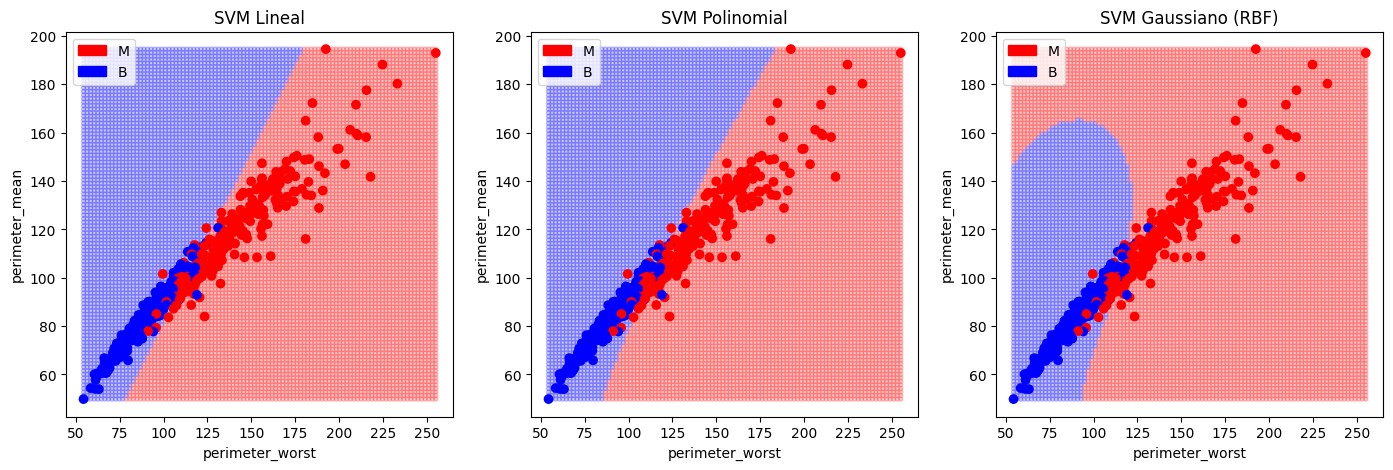

In [40]:
# colores de las regiones de decisión
colors_pred = {0:'blue', 1:'red'} 

# Leyendas
red_patch = mpatches.Patch(color='red', label='M')
blue_patch = mpatches.Patch(color='blue', label='B')

fig, axes = plt.subplots(1,3, figsize=(17,5))
# Gráfico SVM Lineal
axes[0].scatter(X_space[:, 0], X_space[:, 1], c = df_pred_lineal["pred"].map(colors_pred), marker = '.', alpha = 0.2)
axes[0].scatter(X.values[:,0],X.values[:,1], color=[colors_pred[r] for r in y.values])
axes[0].legend(handles=[red_patch, blue_patch])
axes[0].set_title('SVM Lineal')
axes[0].set_xlabel('perimeter_worst')
axes[0].set_ylabel('perimeter_mean')

# Gráfico SVM Polinomial
axes[1].scatter(X_space[:, 0], X_space[:, 1], c = df_pred_poly["pred"].map(colors_pred), marker = '.', alpha = 0.2)
axes[1].scatter(X.values[:,0],X.values[:,1], color=[colors_pred[r] for r in y.values])
axes[1].legend(handles=[red_patch, blue_patch])
axes[1].set_title('SVM Polinomial')
axes[1].set_xlabel('perimeter_worst')
axes[1].set_ylabel('perimeter_mean')

# Gráfico SVM Gaussiano
axes[2].scatter(X_space[:, 0], X_space[:, 1], c = df_pred_gauss["pred"].map(colors_pred), marker = '.', alpha = 0.2)
axes[2].scatter(X.values[:,0],X.values[:,1], color=[colors_pred[r] for r in y.values])
axes[2].legend(handles=[red_patch, blue_patch])
axes[2].set_title('SVM Gaussiano (RBF)')
axes[2].set_xlabel('perimeter_worst')
axes[2].set_ylabel('perimeter_mean')

plt.show()

En la celda anterior se pueden apreciar los gráficos que resultan de aplicar el modelo SVM para clasificar los datos. En estos se pueden ver los datos reales en forma de puntos, mientras que, de tonalidad más clara, se pueden ver las fronteras de decisiones que se obtienen de SVM al usar distintos kernels.  
Se puede ver que, para los parámetros por defecto de sklearn, el kernel lineal y polinomial arrojan el mismo resultado, sin embargo, el kernel gaussiano genera una región completamente distinta para su clasificación.  

Por último, debido a que los datos no se ven en gran medida separables linealmente, se considera el uso de SVM con kernel gaussiano una mejor opción para este problema.

### 3. Selección de modelo

#### (a)

Se creará un modelo que permita obtener la curva ROC. Para ello, se define una función que calcule los ratios de verdaderos y falsos positivos, para luego con una lista de umbrales poder obtener varios puntos con estos dos ratios y ser capaces de graficarlos.

In [29]:
def curva_ROC(y_true, y_score, umbral):
  """Calcula la Receiver operating characteristic (ROC).

    Parameters
    ----------
    y_true : ndarray 
        Valores binarios representantes de las clases reales de los datos.
        Estos valores deben ser {0, 1}.

    y_score : ndarray
        Probabilidad de un dato a pertenecer a alguna clase. Esta debe ser entre
        0 y 1.

  Returns
  -------
  fpr : ndarray 
      Ratio de falsos positivos tal que el elemento i es el ratio de falsos
      positivos de la predicción con score >= umbral[i].

  tpr : ndarray 
      Ratio de verdaderos positivos tal que el elemento i es el ratio de verdaderos
      positivos de la predicción con score >= umbral[i].
  """
  # Array de predicciones en base a las probabilidades y el umbral
  y_true = np.array(y_true)
  y_prob = []

  # Se itera por probabiidad
  for i in range(len(y_score)):
    y_prob.append(y_score[i][1])
  y_pred = np.where(y_prob >= umbral, 1, 0)

  # Falsos y verdaderos positivos y negativos
  fp = np.sum((y_pred == 1) & (y_true == 0))
  tp = np.sum((y_pred == 1) & (y_true == 1))
  fn = np.sum((y_pred == 0) & (y_true == 1))
  tn = np.sum((y_pred == 0) & (y_true == 0))

  # Calcular ratios
  fpr = fp/(tn+fp)
  tpr = tp/(tp+fn)
  
  return fpr, tpr

En la celda anterior se crea una función que permite calcular la curva ROC. Esta curva es tal que, grafica los ratios de verdaderos positivos en el eje y (predicciones correctas del modelo a una clase) y el ratio de falsos positivos en el eje x (datos que el modelo predijo la otra clase incorrectamente). 

Así, mientras la curva ROC esté más alejada de la función identidad $f(x) = x$, indica un mejor resultado de las probabilidades dadas por un modelo de clasificación, mientras que una curva cercana a a identidad, indica un mal desempeño del clasificador.  

Notar que la línea que define la función identidad representa a un clasificador aleatorio con probabilidad $1/2$ a cada clase.

#### (b)

In [30]:
# Separación en conjunto de entrenamiento y testeo con rut de semilla
X = df[['perimeter_worst', 'perimeter_mean']]
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 20470051)

In [31]:
# Se definen nuevamente los clasificadores del inicio por temas de orden.

# Clasificador decision tree
simpletree = DecisionTreeClassifier()
# fit
simpletree.fit(X_train, y_train)

# Clasificador random forest
rf = RandomForestClassifier()
# fit
rf.fit(X_train, y_train)

# Clasificadores SVM con distintos kernels
svm_lineal = svm.SVC(kernel='linear', C=1, probability=True)
svm_poly = svm.SVC(kernel='poly', C=1, degree=2, probability=True)
svm_gauss = svm.SVC(kernel='rbf', C=1, probability=True)
# fit
svm_lineal.fit(X_train, y_train)
svm_poly.fit(X_train, y_train)
svm_gauss.fit(X_train, y_train)
pass

In [32]:
# Calcular probabilidades de cada modelo (uso de sklearn, por esto no va dentro de la función curva ROC)
y_score_tree = simpletree.predict_proba(X_test)
y_score_rf = rf.predict_proba(X_test)
y_score_svm_lineal = svm_lineal.predict_proba(X_test)
y_score_svm_poly = svm_poly.predict_proba(X_test)
y_score_svm_gauss = svm_gauss.predict_proba(X_test)

scores = [y_score_tree, y_score_rf, y_score_svm_lineal, y_score_svm_poly, y_score_svm_gauss]

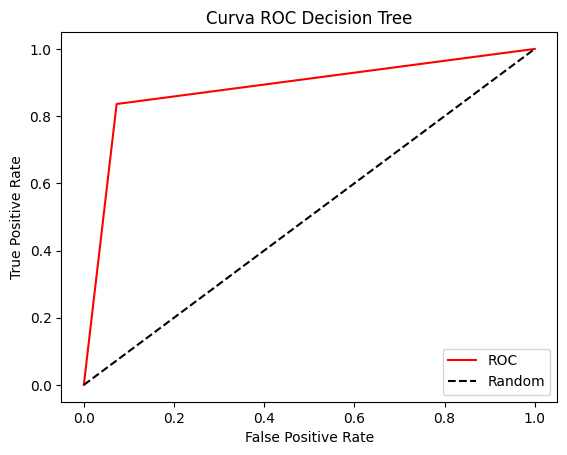

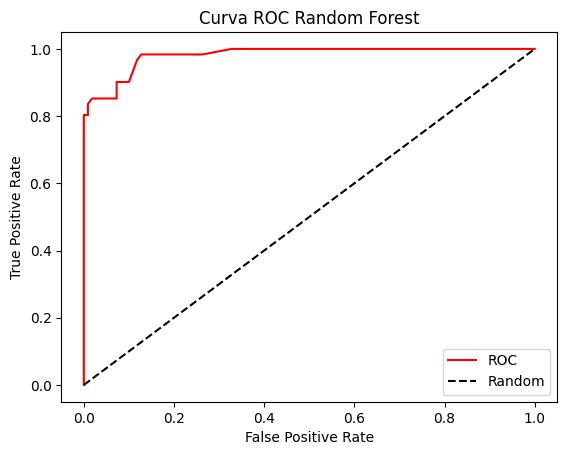

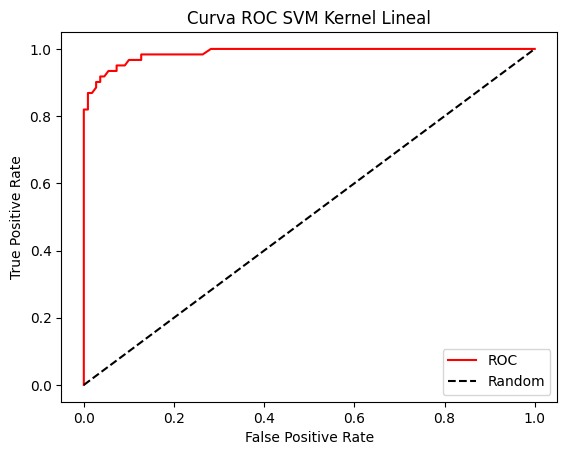

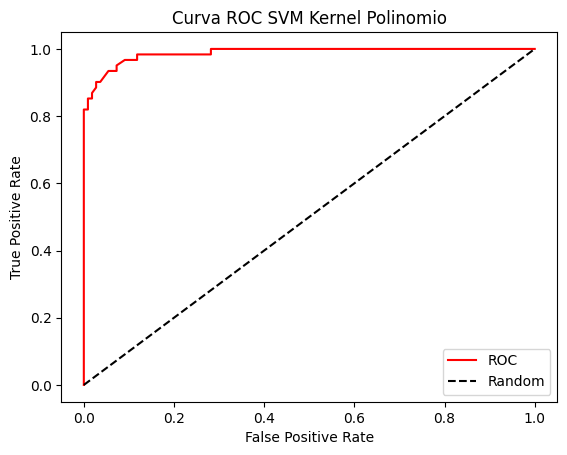

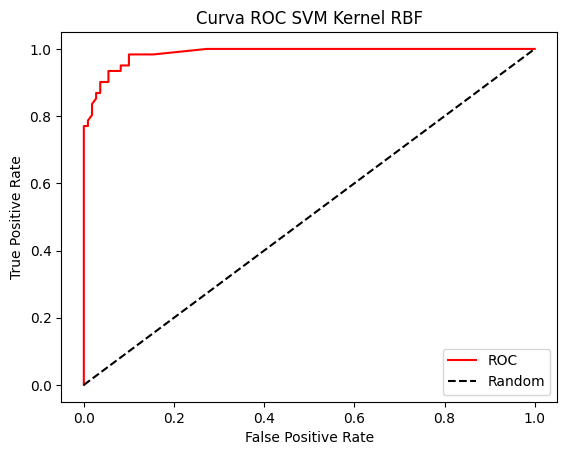

In [33]:
# -------------------- Decision Tree ------------------------

# Generar umbrales e inicializar listas de fpr y tpr
umbrales = np.linspace(0,1,100)
lista_fpr = []
lista_tpr = []

# Generar fpr, tpr para cada umbral
for umbral in umbrales:
  fpr, tpr = curva_ROC(y_test, y_score_tree, umbral)
  lista_fpr.append(fpr)
  lista_tpr.append(tpr)

# Punto para fpr,tpr=0 y graficar correctamente
lista_fpr.append(0) 
lista_tpr.append(0)
plt.plot(lista_fpr, lista_tpr, 'r', label='ROC')
plt.plot([0, 1], [0, 1], '--', c='black', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Decision Tree')
plt.legend(loc='lower right')
plt.show()

# -------------------- Random Forest ------------------------

# Generar umbrales e inicializar listas de fpr y tpr
umbrales = np.linspace(0,1,100)
lista_fpr = []
lista_tpr = []

# Generar fpr, tpr para cada umbral
for umbral in umbrales:
  fpr, tpr = curva_ROC(y_test, y_score_rf, umbral)
  lista_fpr.append(fpr)
  lista_tpr.append(tpr)

# Punto para fpr,tpr=0 y graficar correctamente
lista_fpr.append(0) 
lista_tpr.append(0)
plt.plot(lista_fpr, lista_tpr, 'r', label='ROC')
plt.plot([0, 1], [0, 1], '--', c='black', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Random Forest')
plt.legend(loc='lower right')
plt.show()

# -------------------- SVM Lineal ------------------------

# Generar umbrales e inicializar listas de fpr y tpr
umbrales = np.linspace(0,1,100)
lista_fpr = []
lista_tpr = []

# Generar fpr, tpr para cada umbral
for umbral in umbrales:
  fpr, tpr = curva_ROC(y_test, y_score_svm_lineal, umbral)
  lista_fpr.append(fpr)
  lista_tpr.append(tpr)

# Punto para fpr,tpr=0 y graficar correctamente
lista_fpr.append(0) 
lista_tpr.append(0)
plt.plot(lista_fpr, lista_tpr, 'r', label='ROC')
plt.plot([0, 1], [0, 1], '--', c='black', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC SVM Kernel Lineal')
plt.legend(loc='lower right')
plt.show()

# -------------------- SVM kernel='poly' ------------------------

# Generar umbrales e inicializar listas de fpr y tpr
umbrales = np.linspace(0,1,100)
lista_fpr = []
lista_tpr = []

# Generar fpr, tpr para cada umbral
for umbral in umbrales:
  fpr, tpr = curva_ROC(y_test, y_score_svm_poly, umbral)
  lista_fpr.append(fpr)
  lista_tpr.append(tpr)

# Punto para fpr,tpr=0 y graficar correctamente
lista_fpr.append(0) 
lista_tpr.append(0)
plt.plot(lista_fpr, lista_tpr, 'r', label='ROC')
plt.plot([0, 1], [0, 1], '--', c='black', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC SVM Kernel Polinomio')
plt.legend(loc='lower right')
plt.show()

# -------------------- SVM kernel='rbf' ------------------------

# Generar umbrales e inicializar listas de fpr y tpr
umbrales = np.linspace(0,1,100)
lista_fpr = []
lista_tpr = []

# Generar fpr, tpr para cada umbral
for umbral in umbrales:
  fpr, tpr = curva_ROC(y_test, y_score_svm_gauss, umbral)
  lista_fpr.append(fpr)
  lista_tpr.append(tpr)

# Punto para fpr,tpr=0 y graficar correctamente
lista_fpr.append(0) 
lista_tpr.append(0)
plt.plot(lista_fpr, lista_tpr, 'r', label='ROC')
plt.plot([0, 1], [0, 1], '--', c='black', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC SVM Kernel RBF')
plt.legend(loc='lower right')
plt.show()

En la siguiente celda se comparan el método manual para graficar la curva ROC junto con la implementada y optimizada en sklearn para los mismos clasificadores y conjunto de prueba ya definidos:

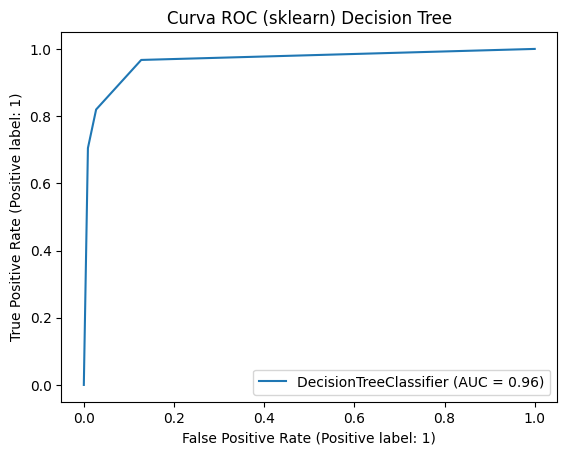

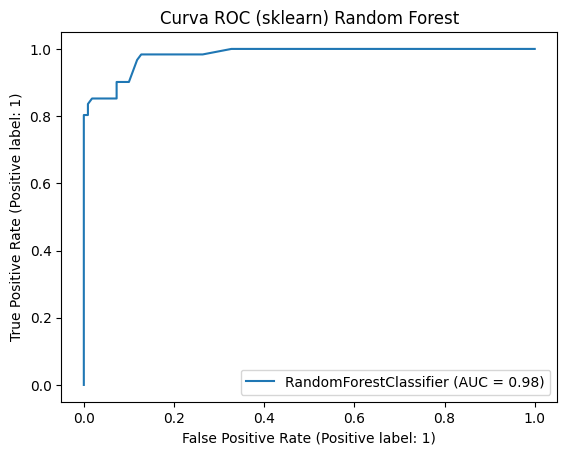

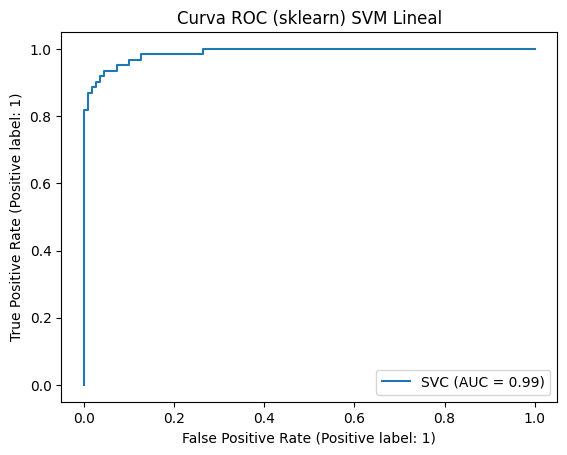

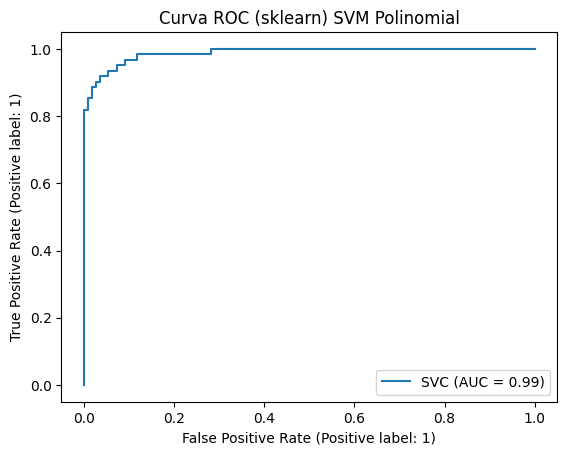

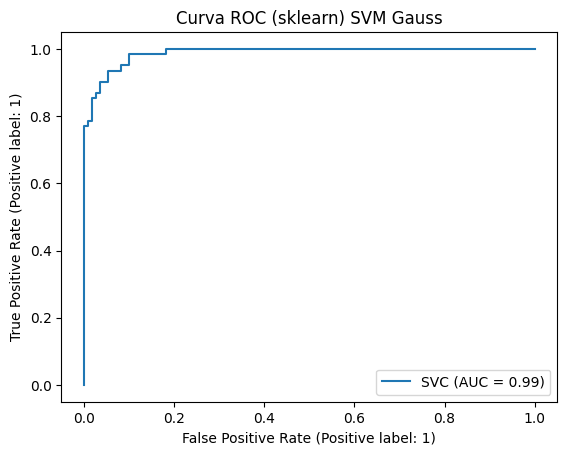

In [42]:
# Comparación con librería sklearn

from sklearn import metrics

metrics.RocCurveDisplay.from_estimator(simpletree, X_test, y_test)
plt.title('Curva ROC (sklearn) Decision Tree')
plt.show()
metrics.RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title('Curva ROC (sklearn) Random Forest')
plt.show()
metrics.RocCurveDisplay.from_estimator(svm_lineal, X_test, y_test)
plt.title('Curva ROC (sklearn) SVM Lineal')
plt.show()
metrics.RocCurveDisplay.from_estimator(svm_poly, X_test, y_test)
plt.title('Curva ROC (sklearn) SVM Polinomial')
plt.show()
metrics.RocCurveDisplay.from_estimator(svm_gauss, X_test, y_test)
plt.title('Curva ROC (sklearn) SVM Gauss')
plt.show()

Como se puede ver, se ha logrado satisfactoriamente un método para poder graficar la curva ROC en estos clasificadores. Notar que, como se dijo en la sección anterior, mientras la curva más se acerque al punto $(x,y) = (0,1)$, más se acerca el clasificador a predecir todo correctamente.  
Así, se puede observar como todos los clasificadores poseen curvas similares, a excepción del modelo más simple puesto a prueba, el árbol de decisión.  
Esto sucede pues es un método menos robusto para este problema que los otros, y está construido con los parámetros predeterminados de sklearn. Además, su construcción no está basada en darle probabilidades a cada clase por lo que su gráfico tiene esta forma más simple.

#### (c)

Observando los gráficos de la sección (b), para este problema parece adecuado elegir el modelo de clasificación SVM con kernel lineal. Esto ya que en el gráfico de las curvas ROC, parecen estar correctamente predichas las clases en más datos que en los clasificadores DecisionTree y RandomForest.  
Comparando luego los distintos kernels que posee el algoritmo de SVM, estos no parecen agregar demasiadas mejoras al modelo, por lo cual guiándose por el tipo de complejidad computacional que tienen estos algoritmos, el modelo lineal es más rápido y ocupa menos memoria que el kernel polinomio y rbf. Esto claramente depende de los datos a trabajar, sin embargo, con este dataset parece ser una buena opción a utilizar.  

Ventajas de utilizar la curva ROC son las siguientes:  


*   Fácil implementación y rápida ejecución.
*   Permite encontrar el umbral óptimo según el problema
*   Interpretable bajo los conceptos de verdaderos y falsos positivos.

Desventajas de utilizar la curva ROC son las siguientes: 

*   No tiene en cuenta los costos asociados con los errores de clasificación.
*   No distingue entre diferentes tipos de errores (Tipo I y Tipo II).
*   Puede no comportarse bien con datos demasiado desbalanceados.



Bajo el contexto de este dataset con información de tumores cancerígenos benignos o malignos, el objetivo es tener la menor cantidad posible de falsos negativos, esto pues en medicina es más importante detectar todos los pacientes con cáncer maligno que equivocarse habiendo etiquetado malignos a un paciente con un cáncer benigno.  
Es por lo anterior que la métrica que más se quiere cerca de $1$ es el `recall`. Para esto, se puede ver directamente en las matrices de confusión, o utilizar alguna métrica que la considere, como por ejemplo `f1-score`.  

En las siguientes celdas se puede ver el reporte de clasificación junto con el f1-score de cada modelo y sus predicciones.

In [35]:
print('Árbol de Decisión:\n')
print(classification_report(y_test, simpletree.predict(X_test)))
print('Random Forest:\n')
print(classification_report(y_test, rf.predict(X_test)))
print('SVM Lineal:\n')
print(classification_report(y_test, svm_lineal.predict(X_test)))
print('SVM Polinomial:\n')
print(classification_report(y_test, svm_poly.predict(X_test)))
print('SVM RBF:\n')
print(classification_report(y_test, svm_gauss.predict(X_test)))

Árbol de Decisión:

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       110
           1       0.86      0.84      0.85        61

    accuracy                           0.89       171
   macro avg       0.89      0.88      0.88       171
weighted avg       0.89      0.89      0.89       171

Random Forest:

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       110
           1       0.95      0.85      0.90        61

    accuracy                           0.93       171
   macro avg       0.93      0.91      0.92       171
weighted avg       0.93      0.93      0.93       171

SVM Lineal:

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       110
           1       0.96      0.87      0.91        61

    accuracy                           0.94       171
   macro avg       0.95      0.93      0.93       171
weighted avg       0.94  

In [36]:
print('f1-score árbol de decisión:',metrics.f1_score(y_test, simpletree.predict(X_test)))
print('f1-score random forest:', metrics.f1_score(y_test, rf.predict(X_test)))
print('f1-score SVM lineal:', metrics.f1_score(y_test, svm_lineal.predict(X_test)))
print('f1-score SVM polinomio:', metrics.f1_score(y_test, svm_poly.predict(X_test)))
print('f1-score SVM Gaussiano:', metrics.f1_score(y_test, svm_gauss.predict(X_test)))

f1-score árbol de decisión: 0.85
f1-score random forest: 0.8965517241379309
f1-score SVM lineal: 0.9137931034482758
f1-score SVM polinomio: 0.9043478260869565
f1-score SVM Gaussiano: 0.8750000000000001


Con esto, finalmente se verifica de mejor manera que el modelo óptimo para este problema es el SVM con kernel lineal, pues posee mayor recall para la clase 1 (Maligno) obteniendo también la mejor puntuación en la métrica f1-score.